Name: B.S.V.W. Munasinghe

Index Number: 190397E

In [2]:
#Importing Libraries
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

* Calculating $K_i,R_i,t_i$ and Camera metrices for $i=1,2$

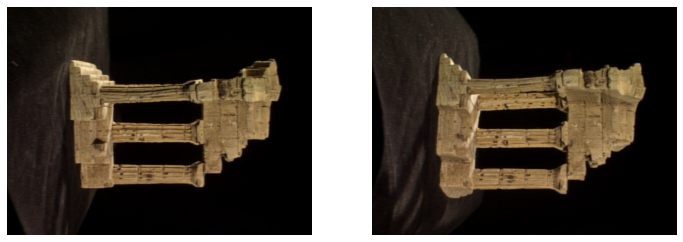

In [21]:
f = open(r'templeSparseRing/templeSR_par.txt','r')
assert f is not None

n = int(f.readline())

#Read the information of the first image
l = f.readline().split()
im1_fn = l[0]

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Read the information of the second image
l = f.readline().split()
im2_fn = l[0]

K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

P1 = K1 @ np.hstack((R1,t1)) #P = K*[R|t]
P2 = K2 @ np.hstack((R2,t2)) #P = K*[R|t]

img1 = cv.imread('templeSparseRing/templeSR0001.png',cv.IMREAD_COLOR) 
assert img1 is not None
img2 = cv.imread('templeSparseRing/templeSR0002.png',cv.IMREAD_COLOR) 
assert img1 is not None

fig,ax = plt.subplots(1,2,figsize=(12,12))
i1 = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
i2 = cv.cvtColor(img2,cv.COLOR_BGR2RGB)
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(i1)
ax[1].imshow(i2)

# Finding SIFT matches

In [10]:
sift = cv.SIFT_create()
kp1,decs1 = sift.detectAndCompute(img1,None)
kp2,decs2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
searchParams = dict(checks=50)

flann = cv.FlannBasedMatcher(indexParams,searchParams)
matches = flann.knnMatch(decs1,decs2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance<0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
pts1 = np.array(pts1)
pts2 = np.array(pts2)




# Calculating F,E matrices

In [13]:
F,mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
E = K2.T @ F @ K1

# recovering the pose of the second camera with respect to the first

In [14]:
retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)

# Computing camera matrix p2

In [16]:
R_t_1 = np.concatenate((R1,t1),axis=1) # 3 x 4 matrix
R_t_2 = np.empty((3,4))

R2_= R1 @ R
t2_ = R1 @ t

R_t_2 = np.concatenate((R2_,t2_),axis=1)

p2_ = K2 @ R_t_2

# 3D plot

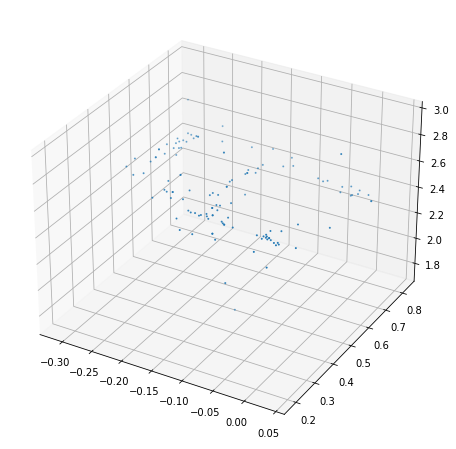

In [20]:
points4D = cv.triangulatePoints(P1,p2_,pts1.T,pts2.T)
points4D /= points4D[3,:]

X = points4D[0,:]
Y = points4D[1,:]
Z = points4D[2,:]

fig=plt.figure(figsize=(8,8))

ax = fig.add_subplot(111,projection='3d')

ax.scatter(X,Y,Z,s=1,cmap='gray')
plt.show()